# init
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de

## Tasks
- get OpenStreetMap data using the osmnx functionalities in the Overpass API
- clip it to an AOI

## Prerequisites
- have osmnx and geopandas installed
- have an AOI saved as a vector (shapefile or geopackage)

In [1]:
import osmnx as ox
import geopandas as gpd
from pathlib import Path

# imports

In [2]:
#import the AOI
AOI_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
AOI_file = 'JAK_LIM_BoundingBox_AOI_A.shp'
AOI_gdf = gpd.read_file(AOI_path / AOI_file)

In [3]:
#bounds provides minx, miny, maxx, maxy
aoi_coords = AOI_gdf.to_crs(epsg='4326').envelope
bbox_df = gpd.GeoDataFrame(geometry=aoi_coords)
print('N',aoi_coords.bounds.values[0][3],'S',aoi_coords.bounds.values[0][1],'W',aoi_coords.bounds.values[0][0],'E',aoi_coords.bounds.values[0][2])

N -5.924775462093303 S -6.78749996341632 W 106.25833288099368 E 107.23811669088865


<Axes: >

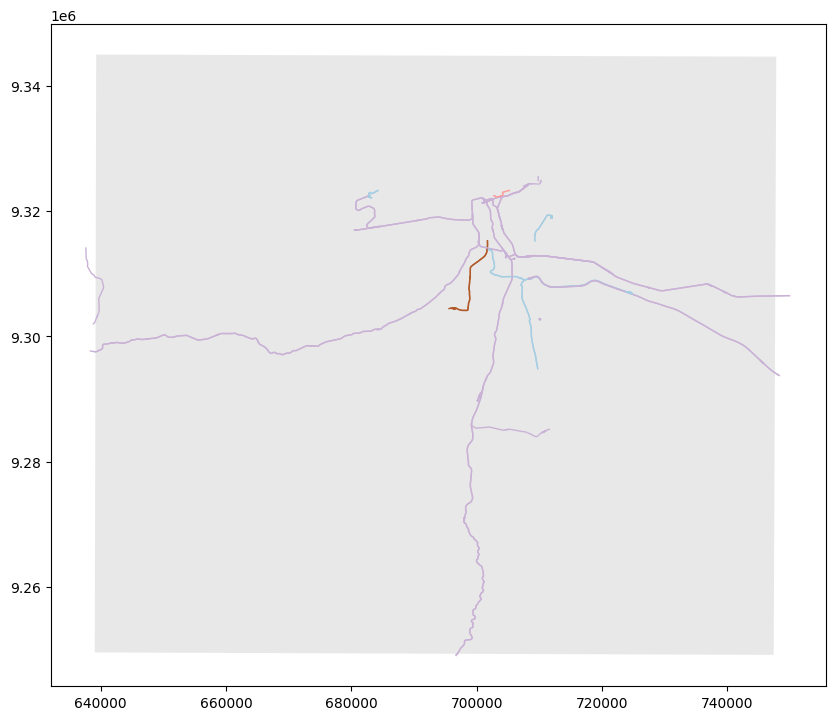

In [4]:
#get rail features from OSM
# List key-value pairs for tags
tags = {'railway': ['light_rail', '	monorail', 'narrow_gauge', 'rail', 'subway', '	tram']}
col_list = ['osmid','name','source','geometry', 'railway','usage'] #OSM has hundreds of cols, we just want a few. For info, check https://wiki.openstreetmap.org/wiki/Key:railway

rail = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                              south=aoi_coords.bounds.values[0][1],
                              west=aoi_coords.bounds.values[0][0],
                              east=aoi_coords.bounds.values[0][2],
                              tags=tags)
rail.reset_index(inplace=True)

#filtering out the wrong geometries (POLYGON or POINT) and element types (NODE)
rail = rail.loc[(rail.geometry.type=='LineString'), col_list] #&(rail.element_type == 'way')
#convert the CRS of roads to the same as AOI
rail.to_crs(AOI_gdf.crs,inplace=True)

#plot them
rail.plot('railway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2)

<Axes: >

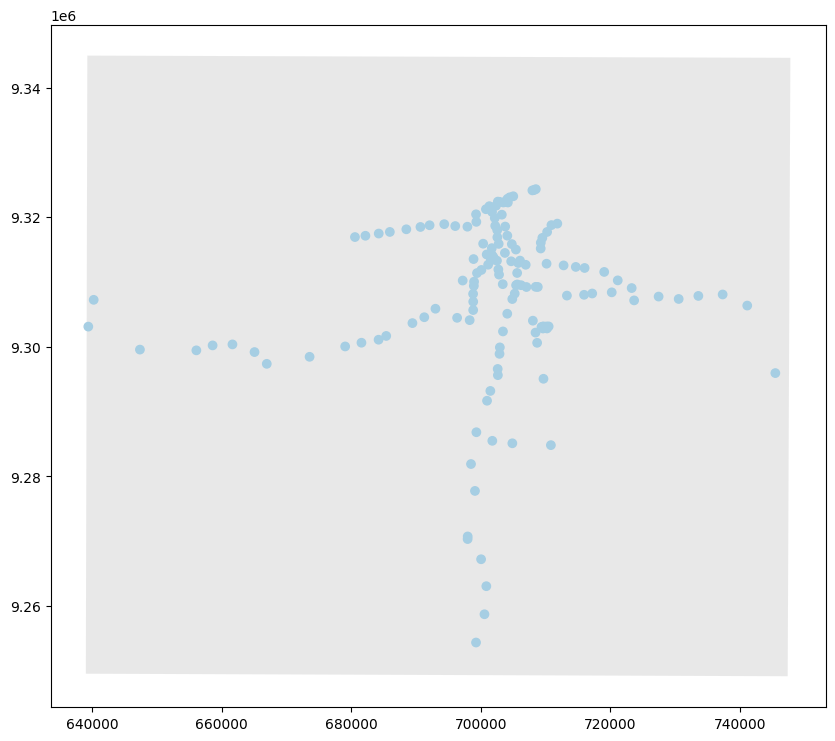

In [9]:
# get points with stations from OSM
# List key-value pairs for tags
tags = {'railway': ['station']} # see https://wiki.openstreetmap.org/wiki/Key:railway for more info
col_list = ['osmid','name','geometry', 'railway','line_served', 'network'] #OSM has hundreds of cols, we just want a few. For info, check https://wiki.openstreetmap.org/wiki/Tag:railway%3Dsubway

stations = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                              south=aoi_coords.bounds.values[0][1],
                              west=aoi_coords.bounds.values[0][0],
                              east=aoi_coords.bounds.values[0][2],
                              tags=tags)
stations.reset_index(inplace=True)

#filtering out the wrong geometries (POLYGON or POINT) and element types (NODE)
stations = stations.loc[(stations.geometry.type=='Point'), col_list] #&(places.element_type == 'way')
#convert the CRS of roads to the same as AOI
stations.to_crs(AOI_gdf.crs,inplace=True)

#plot them
stations.plot('railway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,

In [10]:
stations.columns

Index(['element_type', 'osmid', 'line_served', 'name', 'name:zh',
       'public_transport', 'railway', 'station', 'train', 'geometry',
       'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street',
       'alt_name', 'network', 'network:wikidata', 'operator', 'wikidata',
       'wikipedia', 'name:ja', 'name:en', 'addr:full', 'source',
       'addr:country', 'light_rail', 'nodes', 'building', 'layer', 'ref',
       'wheelchair', 'ele', 'disused:railway', 'railway:ref', 'electrified',
       'gauge', 'wikimedia_commons', 'addr:district', 'addr:province',
       'name:ko', 'petarakyat', 'stop_code', 'stop_id', 'wikipedia:en',
       'opening_hours', 'air_conditioning', 'subway', 'platforms',
       'description', 'internet_access', 'access:roof', 'note', 'amenity',
       'website', 'elevation'],
      dtype='object')

<Axes: >

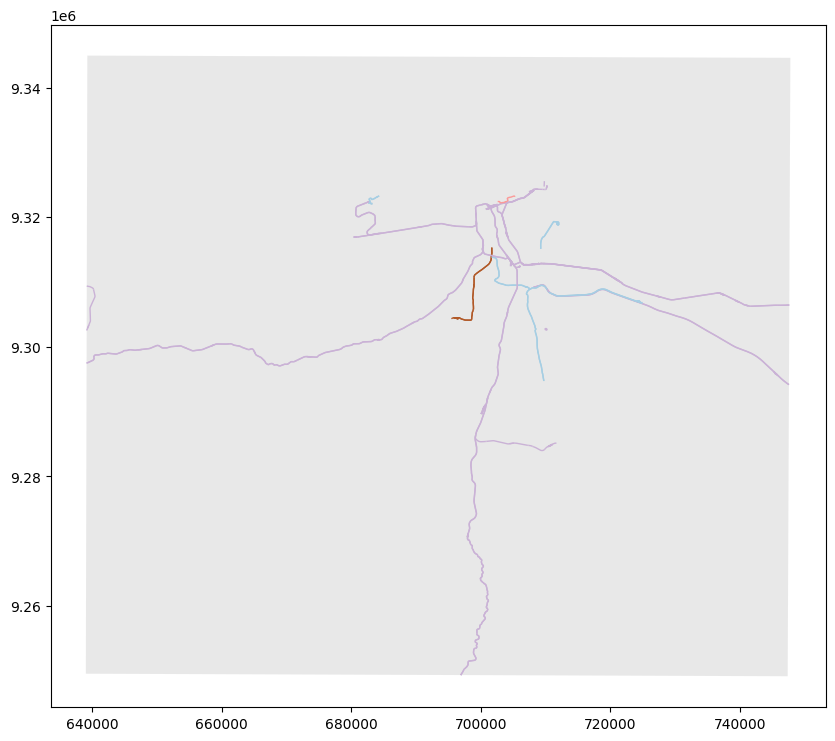

In [6]:
#clip using geopandas, the mask is the AOI we imported above
rail_clipped = gpd.clip(rail, mask=AOI_gdf, keep_geom_type=True)
rail_clipped.plot('railway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2)

# export

In [7]:
#export roads  to a shapefile
rail_clipped.to_file(AOI_path / 'JAK_TRA_railways_OSM_2024_L.shp')

In [8]:
#export places to a shapefile
stations.to_file(AOI_path / 'JAK_TRA_stations_OSM_2024_P.shp')